# Variational Autoencoder

Autoencoders are neural network architectures used to:
* Encoder data - Create lower-dimension representations of input data.
* Decode data - From these lower-dimension representations, re-create the input data.

Variational autoencoders are a form of autoencoder that learns latent (lower-dimensional) *distribution* of inputs' mean and standard deviation. There is then a **sampling** layer after the latent encoding layer that samples from these mean and standard deviation distributions, 'generating' a new, realistic synthetic observation.

In [216]:
# Commented out for non-Colab user

# # re upload files everytime run

# from google.colab import files

# uploaded = files.upload()

### Options

* `pass_only` - True if only want to generate normative data
* `scale` - True if want to scale all columns to (0,1) scale
* `multi-activation` - True if want output layer to have multiple activation functions (experimental)

In [217]:
pass_only = False
scale = True
multi_activation = True

# Environment Set-up

## Libraries

In [218]:
## Load libraries

# Data manipulation
import pandas as pd
import numpy as np
print('numpy: %s' % np.__version__)

# Deep learning
from tensorflow import concat
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)

from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from keras import backend as K

# Plotting
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE
print('matplotlib: %s' % matplotlib.__version__)

import graphviz
print('graphviz: %s' % graphviz.__version__)

import plotly
import plotly.express as px
print('plotly: %s' % plotly.__version__)

import seaborn as sns

# Other
import sys
import os

main_dir=os.path.dirname(sys.path[0])
print('main dir: %s' % main_dir)

numpy: 1.22.3
Tensorflow/Keras: 2.9.0
matplotlib: 3.5.1
graphviz: 0.20.1
plotly: 5.10.0
main dir: /Users/benjamintan/Library/CloudStorage/OneDrive-TheUniversityofWesternAustralia/Master of Data Science/Year 2/Semester 2/CITS5553/CITS5553-Capstone-Project/GAN


## Loading Data

In [219]:
import pandas as pd

full_data = pd.read_csv('wba_data_CLEAN.csv')
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X = pd.concat([X_train, y_train], axis=1)
X_valid = pd.concat([X_test, y_test], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(191, 120)
(191, 1)
(48, 120)
(48, 1)


In [220]:
freq_cols = [c for c in X.columns if c[:2] == "f("]

In [221]:
if pass_only:
    X = X[X['OverallPoF'] == 0]
    X = X.drop(columns=['OverallPoF'])
    X_valid = X_valid[X_valid['OverallPoF'] == 0]
    X_valid = X_valid.drop(columns=['OverallPoF'])

    y_train = y_train[y_train['OverallPoF'] == 0]
    y_test = y_test[y_test['OverallPoF'] == 0]

## Data Standardisation

In [222]:
from sklearn.preprocessing import MinMaxScaler

if scale:
    # Scale all columns to (0,1) range
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.fit_transform(X_valid)
else:
    X_train_scaled = X.copy()
    X_test_scale = X_valid.copy()

# VAE

### Sampling Layer + Reparameterization Trick

The sampling layer samples from the distributions in the latent layer. However, this makes it difficult to train the network using backpropagation. Backpropagation involves calculating the change in error/loss function with respect to changes in model weights. However, this layer involves *sampling* from distributions in the previous layer and the 'randomness' of sampling means that the aforementioned differentiation cannot be calculated. This makes the sampling layer a 'blockage' to backpropagation.\
\
To tackle this, the **reparameterization trick** is used. By making the latent vector $\mu + \sigma * \epsilon$ (i.e., multiplying $\sigma$ by $\epsilon$), where $\epsilon$ ~ Norm(0,1), a neuron is added to the sampling layer which allows backpropagation to continue through previous layers. **Read more

In [223]:
def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.) ## reparameterisation trick
  return z_mean + K.exp(z_log_sigma) * epsilon

### Encoder

The encoder takes in an *n*-dimensional input and reduces it to (`latent_dim`) latent dimensions.

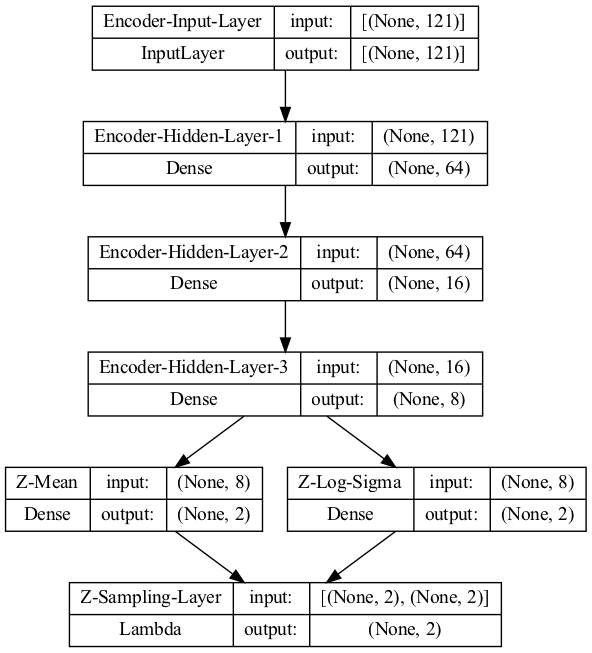

In [224]:
## Encoder
original_dim = len(X.columns)
latent_dim = 2

visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

h_enc1 = Dense(units=64, activation='selu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='selu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='selu', name='Encoder-Hidden-Layer-3')(h_enc2)

z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])

encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

plot_model(encoder, show_shapes=True, dpi=100)

### Decoder

The decoder re-constructs (a variant of, in this case) the initial input, by sampling from the mean and standard deviation distributions in the latent layer.

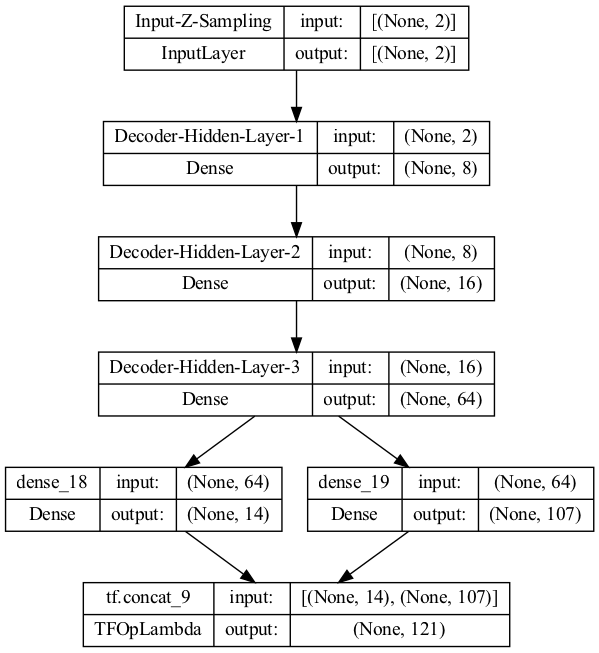

In [225]:
## Decoder
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

h_dec = Dense(units=8, activation='selu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='selu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='selu', name='Decoder-Hidden-Layer-3')(h_dec2)

## Multi output activation
if multi_activation:
    output_1 = Dense(units = len(X.columns) - len(freq_cols), activation=None)(h_dec3)
    output_2 = Dense(units = len(freq_cols), activation='sigmoid')(h_dec3)
    outputs = concat([output_1, output_2], axis=1)
##
else:
# Single output activation
    outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

decoder = Model(latent_inputs, outputs, name='Decoder-Model')

plot_model(decoder, show_shapes=True, dpi=100)

In [226]:
## Autoencoder

# From above:
# visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

outpt = decoder(
    encoder(visible)[2] # Encode the input and take the 3rd element of the output (z-score)
    )

# Set mode parameters (number of inputs/outputs)
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

### Loss Function

We use mean-squared error loss (i.e., mean squared difference between encoder input and decoder output).

**KL-Divergence**\
As variational autoencoders sample from distributions with, in this case, the goal of generating *new* samples, the loss function needs to be altered for that goal. In other words, we don't want the output to be exactly the same as the input - we want features of the output to come from the same distributions as features from the input, such that the output is a realistic synthetic observation that can be used for analysis.\
Thus, we add a *Kullback-Leibler (KL) Divergence* term, which calculates the difference between **probability distributions**. 

In [227]:
## Loss Function
r_loss = original_dim * keras.losses.mse(visible, outpt)
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(r_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### Model Training

Epoch 1/25
12/12 [==============================] - 1s 50ms/step - loss: 18.0609 - val_loss: 12.5414
Epoch 2/25
12/12 [==============================] - 0s 28ms/step - loss: 10.2058 - val_loss: 9.7262
Epoch 3/25
12/12 [==============================] - 0s 27ms/step - loss: 8.2108 - val_loss: 9.4439
Epoch 4/25
12/12 [==============================] - 0s 33ms/step - loss: 7.2475 - val_loss: 9.2832
Epoch 5/25
12/12 [==============================] - 1s 59ms/step - loss: 6.8146 - val_loss: 8.7321
Epoch 6/25
12/12 [==============================] - 1s 62ms/step - loss: 6.5957 - val_loss: 8.9105
Epoch 7/25
12/12 [==============================] - 1s 47ms/step - loss: 6.3076 - val_loss: 8.9447
Epoch 8/25
12/12 [==============================] - 0s 40ms/step - loss: 6.1356 - val_loss: 8.3347
Epoch 9/25
12/12 [==============================] - 0s 27ms/step - loss: 5.8632 - val_loss: 8.4936
Epoch 10/25
12/12 [==============================] - 0s 27ms/step - loss: 5.9387 - val_loss: 7.9025
Epoch 

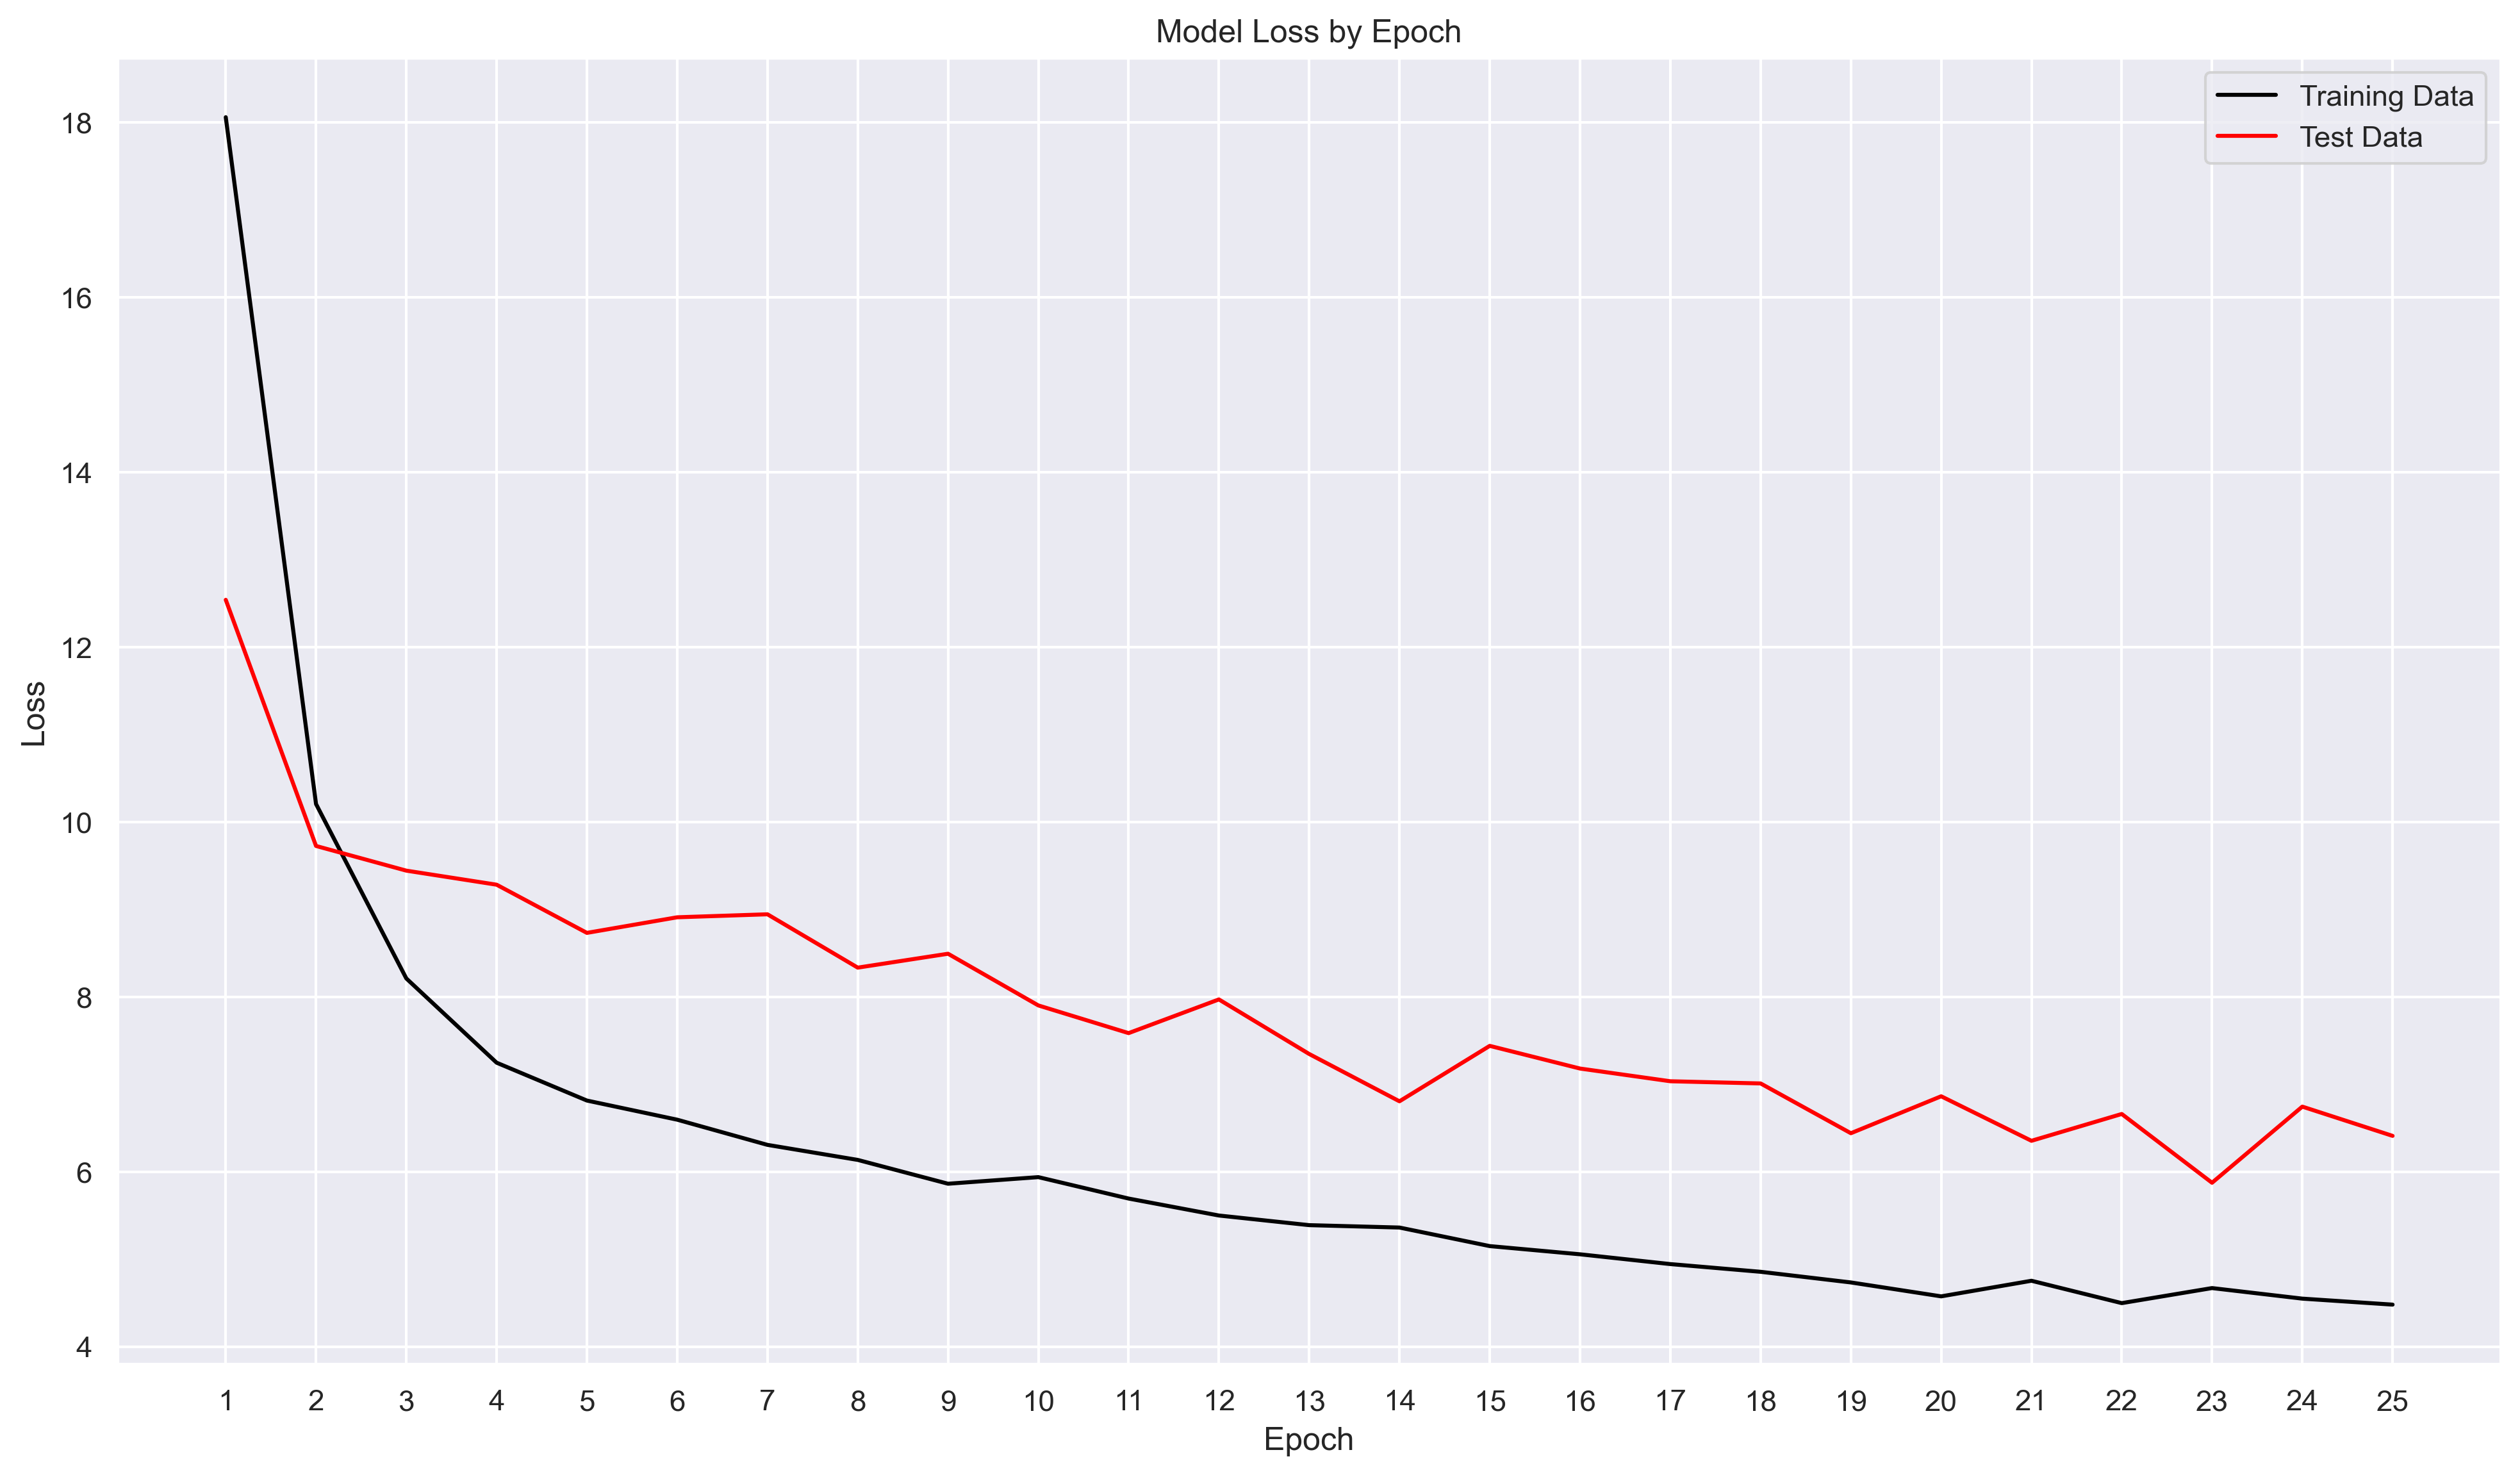

In [228]:
## Training

history = vae.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=16, validation_data=(X_test_scaled, X_test_scaled))

# Plot loss over time
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

In [229]:
if latent_dim == 2:
    ## Visualise Latent Space
    plt.style.use('ggplot')


    X_test_encoded = encoder.predict(X_test_scaled)

    colours = {
        1:"r",
        0:"g"
    }

    fig, ax = plt.subplots()
    # encoder returns 3 arrays, z-mean, z-log-sigma, z
    scatter = ax.scatter(
                        X_test_encoded[2][:,0],
                        X_test_encoded[2][:,1],
                        c=y_test['OverallPoF'].map(colours)
                        )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("WBA Representation in the 2D Latent Space")
    ax.legend(*scatter.legend_elements(), loc="lower left", title="Overall Pass or Fail")
    plt.show()
else:
    print("Cannot visualise latent space for >2 dimensions")

In [230]:
if latent_dim == 2:
    ## Generate from latent space
    z_sample = [[-1.8,-0.3]]
    wba_decoded = decoder.predict(z_sample)
    wba_decoded[0]

In [231]:
from random import seed
from random import random

seed(1)

n_samples = 10000
z_sample = []

for _ in range(n_samples):
  x_value = -3 + (random() * (3--3))
  y_value = -6 + (random() * (6--6))
  z_sample.append([x_value, y_value])

wba_decoded = decoder.predict(z_sample)

unscaled = scaler.inverse_transform(wba_decoded)

313/313 [==============================] - 1s 4ms/step


In [232]:
gen_df = pd.DataFrame(unscaled)
gen_df.columns = X.columns

In [233]:
if not pass_only:
    gen_df['OverallPoF'] = round(gen_df['OverallPoF'])

In [234]:
freq_cols = [c for c in gen_df.columns if c[:2] == "f("]

In [235]:
if pass_only:
    gen_df_long = gen_df[freq_cols].copy(deep=True)
    gen_df_long = gen_df_long.melt()
else:
    gen_df_long = gen_df[freq_cols + ['OverallPoF']].copy(deep=True)
    gen_df_long = gen_df_long.melt(['OverallPoF'])

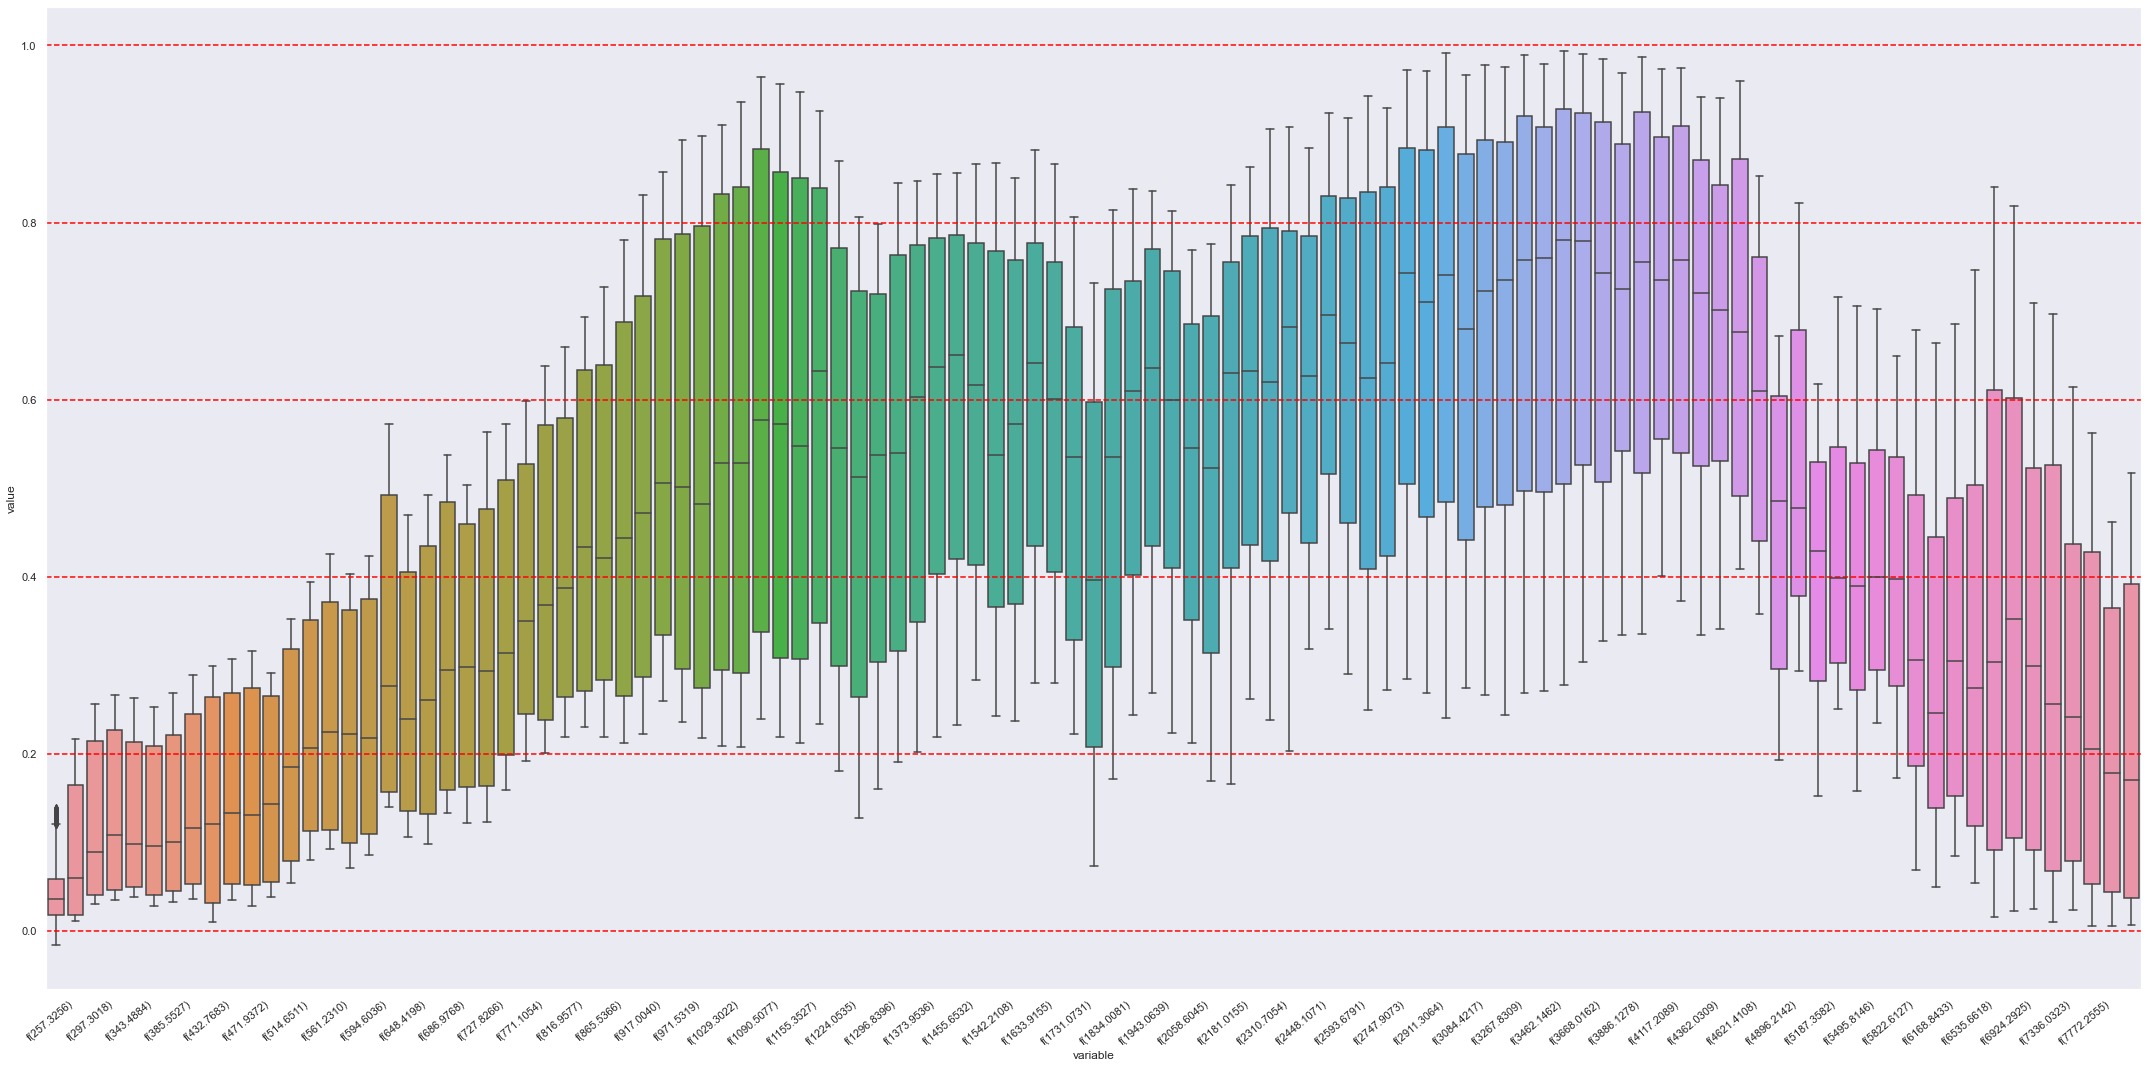

In [236]:
sns.set(rc={'figure.figsize':(30,15)})
ax = sns.boxplot(x="variable", y="value", data=gen_df_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

<ipython-input-237-fd369153a724>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


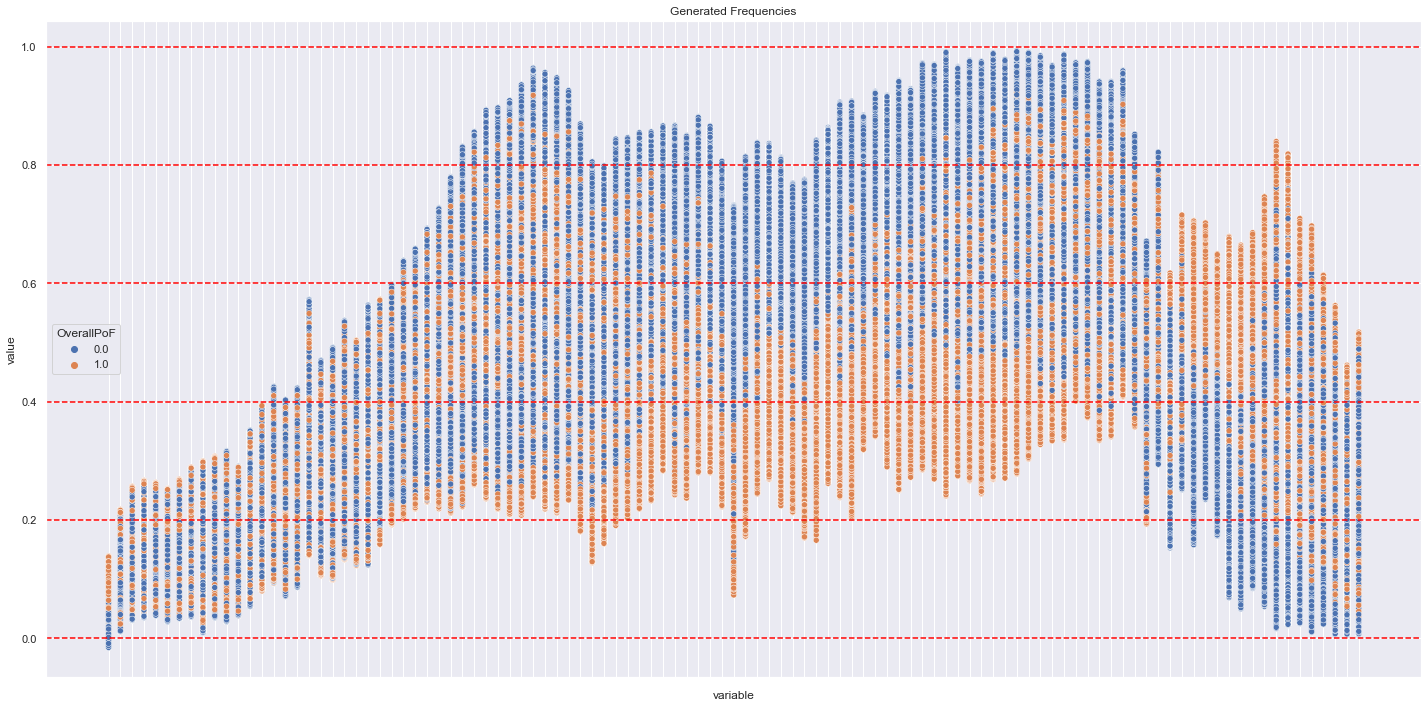

In [237]:
if not pass_only:
    ax = sns.scatterplot(data = gen_df_long, x='variable', y='value', hue='OverallPoF')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set(title="Generated Frequencies")

    # Horizontal lines
    ax.axhline(1, ls='--', color='red')
    ax.axhline(0.8, ls='--', color='red')
    ax.axhline(0.6, ls='--', color='red')
    ax.axhline(0.4, ls='--', color='red')
    ax.axhline(0.2, ls='--', color='red')
    ax.axhline(0.0, ls='--', color='red')

    plt.setp(ax.get_xticklabels()[::2], visible=False)

    plt.tight_layout()
    plt.show();

In [238]:
if not pass_only:
    gen_df['OverallPoF'].value_counts()

In [239]:
gen_df.describe()

,Gender,AgeY,ECV,TPP,SC,TympType,OAE1,OAE1.4,OAE2,OAE2.8,...,f(6349.6042),f(6535.6618),f(6727.1713),f(6924.2925),f(7127.1897),f(7336.0323),f(7550.9945),f(7772.2555),f(8000.0000),OverallPoF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.578363,8.646746,1.141595,-164.695343,0.884403,0.105513,15.736547,5.528979,7.929632,9.001855,...,0.318725,0.354606,0.367297,0.317630,0.299731,0.265965,0.242409,0.204934,0.214486,0.383700
std,0.383469,0.552555,0.314457,92.790039,0.450707,0.511740,15.227710,11.838714,5.143673,3.804249,...,0.213968,0.271391,0.261910,0.224129,0.233232,0.190180,0.191252,0.159744,0.179235,0.486318
min,0.004642,7.060693,0.237305,-397.522522,-0.313372,-1.076449,-20.120684,-25.827663,-10.300100,1.080860,...,0.053505,0.015902,0.021857,0.024399,0.009424,0.022922,0.005921,0.005703,0.006662,0.000000
25%,0.283509,8.427685,0.974463,-235.885605,0.624084,-0.276862,7.347389,-3.611531,4.283631,6.213001,...,0.118407,0.090890,0.104989,0.091274,0.067527,0.078267,0.053375,0.043466,0.036791,0.000000
50%,0.422061,8.683964,1.158491,-143.281685,0.870285,0.133681,12.293890,6.309269,8.587827,9.202988,...,0.274549,0.303868,0.352265,0.298577,0.256281,0.241379,0.205398,0.178698,0.169985,0.000000
75%,0.895406,8.879878,1.351646,-88.693668,1.070111,0.541365,21.849070,16.085535,11.949170,11.077495,...,0.503459,0.610647,0.601241,0.522896,0.526016,0.436399,0.428091,0.364052,0.391230,1.000000
max,1.460446,10.133369,1.946496,-20.053762,2.248267,1.111915,64.843697,27.425766,16.312113,19.158335,...,0.746595,0.839624,0.818945,0.709431,0.697150,0.614206,0.562396,0.461451,0.517472,1.000000


In [240]:
X.describe()

,Gender,AgeY,ECV,TPP,SC,TympType,OAE1,OAE1.4,OAE2,OAE2.8,...,f(6349.6042),f(6535.6618),f(6727.1713),f(6924.2925),f(7127.1897),f(7336.0323),f(7550.9945),f(7772.2555),f(8000.0000),OverallPoF
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,191.00000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.455497,8.882635,0.995969,-37.221027,0.697246,0.125654,10.402094,12.985864,12.324084,10.384764,...,0.20768,0.181088,0.179198,0.176872,0.163072,0.157693,0.153873,0.160471,0.150965,0.157068
std,0.499324,0.688410,0.226848,59.243475,0.350686,0.332331,6.478693,6.501770,5.790232,4.758320,...,0.19151,0.180150,0.177025,0.169725,0.162553,0.156523,0.159908,0.164976,0.171750,0.364821
min,0.000000,7.750000,0.530000,-296.000000,0.000000,0.000000,-9.600000,-4.800000,-5.700000,-3.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.333333,0.825000,-44.500000,0.485000,0.000000,6.350000,9.300000,9.000000,7.400000,...,0.04340,0.016600,0.021800,0.029750,0.022650,0.031200,0.024100,0.031200,0.006950,0.000000
50%,0.000000,8.666667,0.970000,-16.000000,0.610000,0.000000,10.300000,13.300000,12.000000,11.000000,...,0.18300,0.150700,0.133300,0.135400,0.118700,0.108300,0.103900,0.102900,0.103400,0.000000
75%,1.000000,9.458333,1.115000,-2.000000,0.800000,0.000000,15.000000,17.350000,16.400000,13.950000,...,0.32345,0.283700,0.269400,0.277350,0.260500,0.244750,0.237800,0.244400,0.245200,0.000000
max,1.000000,10.750000,1.810000,51.000000,2.550000,1.000000,25.100000,28.000000,27.000000,22.400000,...,0.91640,0.897900,0.895400,0.879700,0.855800,0.816600,0.774000,0.772400,0.856400,1.000000


In [215]:
# gen_df_long.to_csv("gen_df_long.csv")